In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from google.colab import drive
drive.mount('/content/drive')

#IDEA WE HAD DURING CLASS: Use recommender systems to recommend users certain games based on their user reviews

games_file = "/content/drive/MyDrive/all_games.csv"
games = pd.read_csv(games_file)
display(games)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,name,platform,release_date,summary,meta_score,user_review
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,"November 23, 1998","As a young boy, Link is tricked by Ganondorf, ...",99,9.1
1,Tony Hawk's Pro Skater 2,PlayStation,"September 20, 2000",As most major publishers' development efforts ...,98,7.4
2,Grand Theft Auto IV,PlayStation 3,"April 29, 2008",[Metacritic's 2008 PS3 Game of the Year; Also ...,98,7.7
3,SoulCalibur,Dreamcast,"September 8, 1999","This is a tale of souls and swords, transcendi...",98,8.4
4,Grand Theft Auto IV,Xbox 360,"April 29, 2008",[Metacritic's 2008 Xbox 360 Game of the Year; ...,98,7.9
...,...,...,...,...,...,...
18795,Fast & Furious: Showdown,Xbox 360,"May 21, 2013",Fast & Furious: Showdown takes some of the fra...,22,1.3
18796,Drake of the 99 Dragons,Xbox,"November 3, 2003",Drake is out for revenge in a supernatural Hon...,22,1.7
18797,Afro Samurai 2: Revenge of Kuma Volume One,PlayStation 4,"September 22, 2015","Head out on a journey of redemption, driven by...",21,2.9
18798,Infestation: Survivor Stories (The War Z),PC,"October 15, 2012","(Formerly known as ""The War Z"") It has been 5 ...",20,1.7


Next, we can perform some operations on our dataset to tidy it up and make it easier to work with.

In [ ]:
# Some games have a user review of "tbd". Let's change that to NaN.
# Also, critic reviews are integers from 0-100, while user reviews are floats scaled from 0-10. Let's scale user reviews so they're out of 0-100.
games["user_review"] = games["user_review"].apply(lambda x: np.nan if x == "tbd" else (int)(float(x) * 10))

# For some reason, every entry in the platform column has a whitespace character at the start. We can strip this whitespace.
games["platform"] = games["platform"].apply(lambda x: x.strip())

# Each entry in the release_date column is of type string, instead of datetime. Let's change it to type datetime, so it's easier to work with.
games["release_date"] = games["release_date"].apply(lambda x: datetime.datetime.strptime(x, "%B %d, %Y"))

# And while we're at it, let's drop games that don't currently have a user review.
games.dropna(subset = ["user_review"], inplace = True)

games.reset_index(inplace = True)
display(games)

,index,name,platform,release_date,summary,meta_score,user_review
0,0,The Legend of Zelda: Ocarina of Time,Nintendo 64,1998-11-23,"As a young boy, Link is tricked by Ganondorf, ...",99,91.0
1,1,Tony Hawk's Pro Skater 2,PlayStation,2000-09-20,As most major publishers' development efforts ...,98,74.0
2,2,Grand Theft Auto IV,PlayStation 3,2008-04-29,[Metacritic's 2008 PS3 Game of the Year; Also ...,98,77.0
3,3,SoulCalibur,Dreamcast,1999-09-08,"This is a tale of souls and swords, transcendi...",98,84.0
4,4,Grand Theft Auto IV,Xbox 360,2008-04-29,[Metacritic's 2008 Xbox 360 Game of the Year; ...,98,79.0
...,...,...,...,...,...,...,...
17430,18795,Fast & Furious: Showdown,Xbox 360,2013-05-21,Fast & Furious: Showdown takes some of the fra...,22,13.0
17431,18796,Drake of the 99 Dragons,Xbox,2003-11-03,Drake is out for revenge in a supernatural Hon...,22,17.0
17432,18797,Afro Samurai 2: Revenge of Kuma Volume One,PlayStation 4,2015-09-22,"Head out on a journey of redemption, driven by...",21,29.0
17433,18798,Infestation: Survivor Stories (The War Z),PC,2012-10-15,"(Formerly known as ""The War Z"") It has been 5 ...",20,17.0


For the purposes of this project, we will divide each game into one of two categories: "old" or "new", depending on which console the game was released for. Old consoles are consoles that first released before 2002, and new consoles are consoles that first released after 2003.

In [ ]:
print(games["platform"].drop_duplicates())

0            Nintendo 64
1            PlayStation
2          PlayStation 3
3              Dreamcast
4               Xbox 360
5                    Wii
7               Xbox One
10                    PC
13                Switch
14         PlayStation 2
16         PlayStation 4
18              GameCube
21                  Xbox
26                 Wii U
53      Game Boy Advance
79                   3DS
120        Xbox Series X
122                   DS
141     PlayStation Vita
157        PlayStation 5
328                  PSP
3879              Stadia
Name: platform, dtype: object


This is a list of all consoles that have at least one game in our dataset. We can then divide this list into old and new consoles and create two dataframes, one for each category.

In [ ]:
old_games_list = ["Nintendo 64", "PlayStation", "Dreamcast", "PlayStation 2", "GameCube", "Xbox", "Game Boy Advance"]
new_games_list = ["PlayStation 3", "Xbox 360", "Wii", "Xbox One", "Switch", "PlayStation 4", "Wii U", "3DS", "Xbox Series X", "DS", "PlayStation Vita", "PlayStation 5", "PSP", "Stadia"]

old_games = pd.DataFrame()
new_games = pd.DataFrame()
for index, row in games.iterrows():
  if row["platform"] in new_games_list:
    new_games = new_games.append(row)
  elif row["platform"] in old_games_list:
    old_games = old_games.append(row)
    
old_games = old_games.reset_index()
new_games = new_games.reset_index()

display(old_games)
display(new_games)

,level_0,index,name,platform,release_date,summary,meta_score,user_review
0,0,0.0,The Legend of Zelda: Ocarina of Time,Nintendo 64,1998-11-23,"As a young boy, Link is tricked by Ganondorf, ...",99.0,91.0
1,1,1.0,Tony Hawk's Pro Skater 2,PlayStation,2000-09-20,As most major publishers' development efforts ...,98.0,74.0
2,3,3.0,SoulCalibur,Dreamcast,1999-09-08,"This is a tale of souls and swords, transcendi...",98.0,84.0
3,12,12.0,Tony Hawk's Pro Skater 2,Dreamcast,2000-11-06,"Hawk's back - with new technology, new pros an...",97.0,62.0
4,14,14.0,Tony Hawk's Pro Skater 3,PlayStation 2,2001-10-28,Challenge up to four friends in online competi...,97.0,75.0
...,...,...,...,...,...,...,...,...
3110,17420,18785.0,Gravity Games Bike: Street Vert Dirt,PlayStation 2,2002-06-27,Gravity Games Bike: Street. Vert. Dirt. delive...,24.0,34.0
3111,17423,18788.0,Legends of Wrestling II,Game Boy Advance,2002-11-25,Legends of Wrestling II takes you through the ...,24.0,36.0
3112,17424,18789.0,Pulse Racer,Xbox,2003-01-02,Pulse Racer takes you to a future where racers...,24.0,22.0
3113,17428,18793.0,Charlie's Angels,GameCube,2003-07-09,"Join Natalie, Dylan, and Alex for an intense a...",23.0,43.0


,level_0,index,name,platform,release_date,summary,meta_score,user_review
0,2,2.0,Grand Theft Auto IV,PlayStation 3,2008-04-29,[Metacritic's 2008 PS3 Game of the Year; Also ...,98.0,77.0
1,4,4.0,Grand Theft Auto IV,Xbox 360,2008-04-29,[Metacritic's 2008 Xbox 360 Game of the Year; ...,98.0,79.0
2,5,5.0,Super Mario Galaxy,Wii,2007-11-12,[Metacritic's 2007 Wii Game of the Year] The u...,97.0,91.0
3,6,6.0,Super Mario Galaxy 2,Wii,2010-05-23,"Super Mario Galaxy 2, the sequel to the galaxy...",97.0,91.0
4,7,7.0,Red Dead Redemption 2,Xbox One,2018-10-26,Developed by the creators of Grand Theft Auto ...,97.0,80.0
...,...,...,...,...,...,...,...,...
9655,17425,18790.0,Fighter Within,Xbox One,2013-11-19,Unleash your inner fighter to beat your friend...,23.0,28.0
9656,17427,18792.0,Homie Rollerz,DS,2008-03-05,"Homie Rollerz is a fast-paced, mayhem-laden ka...",23.0,30.0
9657,17429,18794.0,Rambo: The Video Game,PlayStation 3,2014-04-29,RAMBO The Vidoegame puts players in Rambo’s co...,23.0,18.0
9658,17430,18795.0,Fast & Furious: Showdown,Xbox 360,2013-05-21,Fast & Furious: Showdown takes some of the fra...,22.0,13.0


Now that we have our datasets formatted properly, we can display some plots of the data, mainly of review scores over time.

In [ ]:
display(old_games.sort_values(by = "release_date"))
display(new_games.sort_values(by = "release_date"))

,level_0,index,name,platform,release_date,summary,meta_score,user_review
132,350,350.0,Resident Evil,PlayStation,1996-03-30,Raccoon City has been completely overrun by mu...,91.0,91.0
207,608,608.0,Tekken 2,PlayStation,1996-08-25,More than a sequel. The undisputed #1 fighting...,89.0,83.0
47,113,113.0,Super Mario 64,Nintendo 64,1996-09-26,Mario is super in a whole new way! Combining t...,94.0,91.0
832,4357,4403.0,Pilotwings 64,Nintendo 64,1996-09-29,Forget about those other flying games. This is...,80.0,81.0
70,176,176.0,Wipeout XL,PlayStation,1996-09-30,The original scorched the game world and becam...,93.0,86.0
...,...,...,...,...,...,...,...,...
2757,15840,16968.0,Werewolf: The Apocalypse - Earthblood,PlayStation 2,2021-02-04,A unique experience full of savage combat and ...,54.0,38.0
2797,16029,17196.0,Taxi Chaos,PlayStation 2,2021-02-23,Taxi Chaos is a casual arcade racing game wher...,52.0,59.0
2744,15792,16912.0,Harvest Moon: One World,GameCube,2021-03-02,Take a trip around the world in the latest ent...,54.0,44.0
2911,16493,17743.0,Demon Skin,GameCube,2021-04-13,Brutal Hack&Slash game with a challenging comb...,48.0,75.0


,level_0,index,name,platform,release_date,summary,meta_score,user_review
8569,15514,16590.0,Postal,Wii,1997-09-30,We'd like to express our sincere thanks and gr...,56.0,65.0
9374,16958,18290.0,Jeremy McGrath Supercross 2000,PlayStation 4,1999-09-29,Race as or against 11-time Supercross Champ Je...,43.0,80.0
9414,17023,18361.0,Rally Challenge 2000,Xbox 360,2000-06-30,RALLY CHALLENGE 2000 takes you on a scorching ...,41.0,60.0
8724,15791,16911.0,Fighter Destiny 2,PSP,2000-07-14,Enter the arena and do battle with the toughes...,54.0,65.0
8923,16148,17336.0,Sydney 2000,Switch,2000-08-25,"Let the games begin, Mate! Get ready to compet...",51.0,49.0
...,...,...,...,...,...,...,...,...
4392,8037,8248.0,Far Cry 6,PlayStation 5,2021-10-07,Far Cry 6 reveals a Caribbean island simmering...,74.0,48.0
26,61,61.0,Tetris Effect: Connected,Switch,2021-10-08,Tetris Effect: Connected is the original Tetri...,95.0,85.0
239,569,569.0,Metroid Dread,Switch,2021-10-08,Join intergalactic bounty hunter Samus Aran in...,89.0,88.0
440,988,990.0,Disco Elysium: The Final Cut,Switch,2021-10-12,Disco Elysium - The Final Cut is the definitiv...,87.0,87.0


Oddly, the dataset of games for "old" consoles has points with release 
dates as late as 2021. This makes no sense, as the longest lasting old console (PlayStation 2) was discontinued in 2013. Similarly,  the dataset of games for "new" consoles has points with release dates as early as 1997, even though the earliest new console (DS) was released in 2004. Most of these games also do not show up on the search engine on Metacritic's website, which further suggests that they are some kind of outlier.

In [ ]:
old_games["release_year"] = old_games["release_date"].apply(lambda x: (int)(x.year))
new_games["release_year"] = new_games["release_date"].apply(lambda x: (int)(x.year))
display(old_games[old_games["release_year"] > 2013])
display(new_games[new_games["release_year"] < 2004])

,level_0,index,name,platform,release_date,summary,meta_score,user_review,release_year
2653,15365,16410.0,Surgeon Simulator: Anniversary Edition,Dreamcast,2014-08-12,Surgeon Simulator 2013 is a darkly humorous ov...,56.0,51.0,2014
2660,15402,16456.0,Pokemon Shuffle,Game Boy Advance,2015-02-18,"In Pokémon Shuffle, your goal is to clear a se...",56.0,61.0,2015
2662,15404,16458.0,Perception,Game Boy Advance,2017-06-06,A first person narrative horror adventure that...,56.0,61.0,2017
2663,15416,16476.0,Deadly Premonition 2: A Blessing in Disguise,Xbox,2020-07-10,"In the year 2005, FBI agent York visits Le Car...",56.0,54.0,2020
2667,15425,16487.0,Supreme League of Patriots,PlayStation 2,2015-01-29,Don your cape and mask and join the Supreme Le...,56.0,46.0,2015
...,...,...,...,...,...,...,...,...,...
3032,17002,18338.0,Tennis World Tour,PlayStation 2,2018-05-22,The new standard developed by veterans of tenn...,42.0,18.0,2018
3033,17007,18345.0,Rugby 18,PlayStation,2017-10-24,Experience the full intensity of the biggest m...,41.0,38.0,2017
3039,17048,18389.0,Dollhouse,PlayStation 2,2019-05-24,This haunting horror game draws you into the m...,41.0,44.0,2019
3046,17086,18434.0,Tamarin,PlayStation,2020-09-10,SAVE YOUR FAMILY FROM THE INSECT INVASION Expl...,40.0,68.0,2020


,level_0,index,name,platform,release_date,summary,meta_score,user_review,release_year
8521,15439,16505.0,Reign of Fire,Xbox 360,2002-10-22,Fight for mankind as one of the many different...,56.0,75.0,2002
8536,15463,16529.0,Spyro: Enter the Dragonfly,3DS,2002-11-03,Gnasty Gnorc and Ripto are back with a plan to...,56.0,44.0,2002
8543,15474,16542.0,Harry Potter and the Sorcerer's Stone,DS,2003-12-09,The next generation versions of Sorcerer's Sto...,56.0,66.0,2003
8544,15475,16543.0,Contract J.A.C.K.,Wii,2003-11-11,Trained to survive. Paid to kill. Explore the ...,56.0,60.0,2003
8568,15513,16589.0,Cool Boarders 2001,Wii,2000-10-31,Rip it up with 10 World Class professional sno...,56.0,33.0,2000
...,...,...,...,...,...,...,...,...,...
9446,17074,18418.0,Freedom: First Resistance,Switch,2000-12-14,Earth has been invaded by aliens that have for...,40.0,32.0,2000
9464,17100,18448.0,Ultimate Beach Soccer,Xbox 360,2003-11-10,"With flashy moves, laser shows, and DJs, Ultim...",39.0,68.0,2003
9467,17104,18452.0,Air Raid: This Is Not a Drill!,Wii,2003-06-18,"Air Raid immerses you in a mind blowing, reali...",39.0,66.0,2003
9485,17133,18483.0,Universal Studios Theme Parks Adventure,PlayStation 3,2001-12-18,Lights... Camera... PLAY! You're not just a vi...,39.0,32.0,2001


These rows do not make up a large part of the dataset. For the games for old consoles, they make up 95 out of 3115 rows, and for the games for new consoles, they make up 127 out of 9660 rows. To keep the data focused on relevant points, we will remove these rows.

In [ ]:
old_games = old_games[old_games["release_year"] <= 2009]
new_games = new_games[new_games["release_year"] >= 2004]

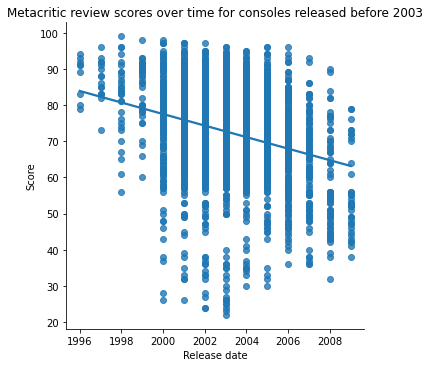

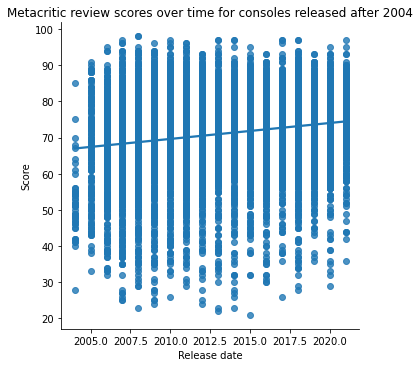

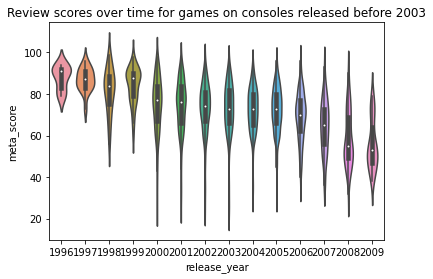

In [ ]:
#plt.scatter(old_games["release_date"], old_games["user_review"], color = "blue", s = 3)
#plt.scatter(old_games["release_date"], old_games["meta_score"], color = "red", s = 3)
sns.lmplot(x = "release_year", y = "meta_score", data = old_games, ci = None, fit_reg = True)
plt.xlabel("Release date")
plt.ylabel("Score")
plt.title("Metacritic review scores over time for consoles released before 2003")
plt.show()

#plt.scatter(new_games["release_date"], new_games["user_review"], color = "blue", s = 3)
#plt.scatter(new_games["release_date"], new_games["meta_score"], color = "red", s = 3)
sns.lmplot(x = "release_year", y = "meta_score", data = new_games, ci = None, fit_reg = True)
plt.xlabel("Release date")
plt.ylabel("Score")
plt.title("Metacritic review scores over time for consoles released after 2004")
plt.show()

sns.violinplot(x = "release_year", y = "meta_score", data = old_games)
plt.title("Review scores over time for games on consoles released before 2003")
plt.show()

#TODO: Format the release_date column to datetime object (Justin) (DONE)
#TODO: Plot linear regression model for meta score over time (Josh) (DONE)
#TODO: Include interactions between certain attributes and find their p-values (Does another attribute significantly effect review score?) (Justin)
#TODO: Boxplot/violinplot of review scores per platform (Josh)